Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8, 1202, 1)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 8, 1600, 1)] 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 1, 293, 8)    2584        input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1, 393, 8)    2584        input_2[0][0]                    
____________________________________________________________________________________________

Fold>> 5
>> Epoch: 5 / 100  >>> Loss: 0.4044671693590085  >>> Acc: 0.8324969
>> Epoch: 10 / 100  >>> Loss: 0.2748655180074041  >>> Acc: 0.8920954
>> Epoch: 15 / 100  >>> Loss: 0.1988822808267182  >>> Acc: 0.9222083
>> Epoch: 20 / 100  >>> Loss: 0.1321503964335736  >>> Acc: 0.9535759
>> Epoch: 25 / 100  >>> Loss: 0.11442267660103  >>> Acc: 0.9535759
>> Epoch: 30 / 100  >>> Loss: 0.081816205551551  >>> Acc: 0.97302383
>> Epoch: 35 / 100  >>> Loss: 0.05938201432479744  >>> Acc: 0.97929734
>> Epoch: 40 / 100  >>> Loss: 0.06434900365966177  >>> Acc: 0.9774153
>> Epoch: 45 / 100  >>> Loss: 0.0479655193484539  >>> Acc: 0.98243415
>> Epoch: 50 / 100  >>> Loss: 0.028205042584872848  >>> Acc: 0.9912171
>> Epoch: 55 / 100  >>> Loss: 0.034056476750872665  >>> Acc: 0.9918444
>> Epoch: 60 / 100  >>> Loss: 0.020372696577570164  >>> Acc: 0.99498117
>> Epoch: 65 / 100  >>> Loss: 0.03297728784715376  >>> Acc: 0.989335
>> Epoch: 70 / 100  >>> Loss: 0.043784353902231586  >>> Acc: 0.9830615
>> Epoch: 75 / 

Fold>> 10
>> Epoch: 5 / 100  >>> Loss: 0.401174644965277  >>> Acc: 0.82769424
>> Epoch: 10 / 100  >>> Loss: 0.2586578626867225  >>> Acc: 0.89849627
>> Epoch: 15 / 100  >>> Loss: 0.18732103697936936  >>> Acc: 0.92606515
>> Epoch: 20 / 100  >>> Loss: 0.14884511572320508  >>> Acc: 0.9404762
>> Epoch: 25 / 100  >>> Loss: 0.10610442646174577  >>> Acc: 0.9649123
>> Epoch: 30 / 100  >>> Loss: 0.09890227940138943  >>> Acc: 0.966792
>> Epoch: 35 / 100  >>> Loss: 0.08386367186437126  >>> Acc: 0.97243106
>> Epoch: 40 / 100  >>> Loss: 0.09036826659087326  >>> Acc: 0.9649123
>> Epoch: 45 / 100  >>> Loss: 0.06321887112220277  >>> Acc: 0.97869676
>> Epoch: 50 / 100  >>> Loss: 0.04399873898189543  >>> Acc: 0.98558897
>> Epoch: 55 / 100  >>> Loss: 0.047170760835938734  >>> Acc: 0.98245615
>> Epoch: 60 / 100  >>> Loss: 0.042276123746643704  >>> Acc: 0.9849624
>> Epoch: 65 / 100  >>> Loss: 0.030238968658203816  >>> Acc: 0.9899749
>> Epoch: 70 / 100  >>> Loss: 0.03180384963405386  >>> Acc: 0.98621553
>> E

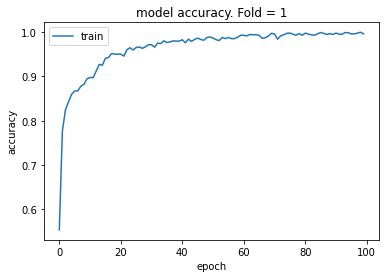

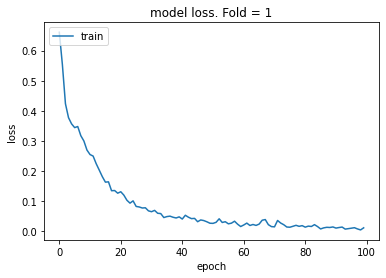

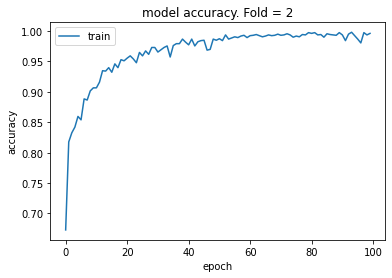

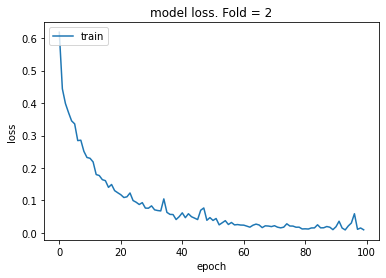

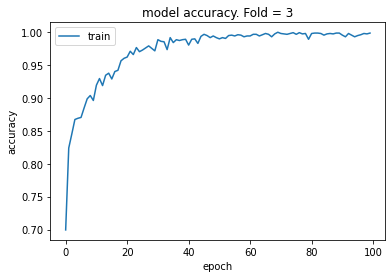

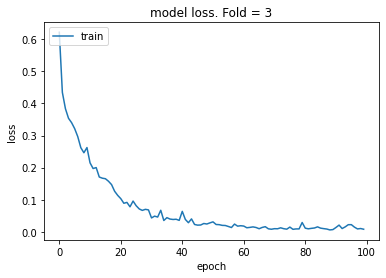

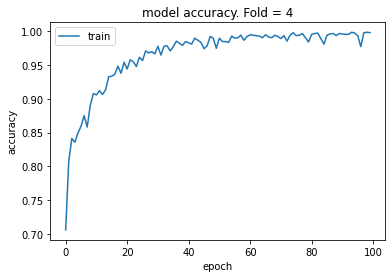

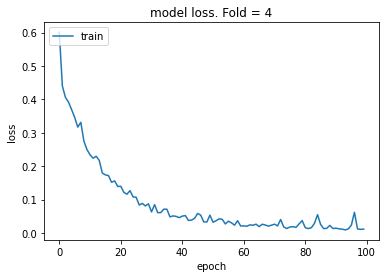

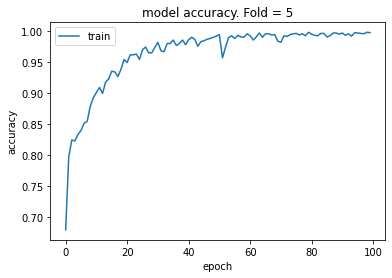

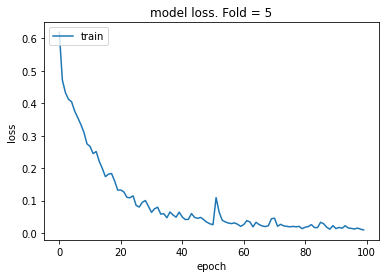

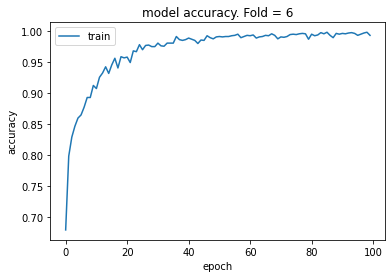

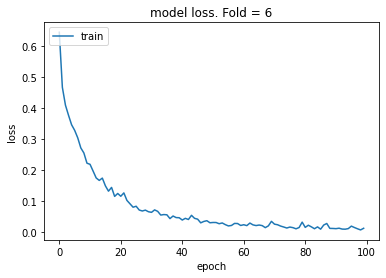

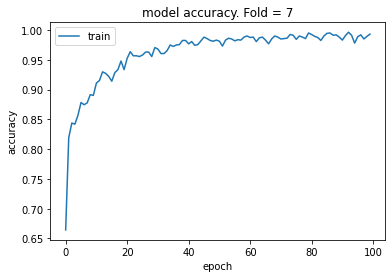

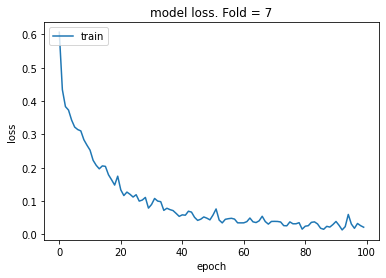

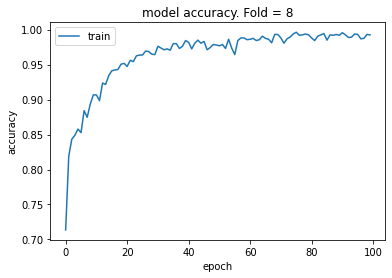

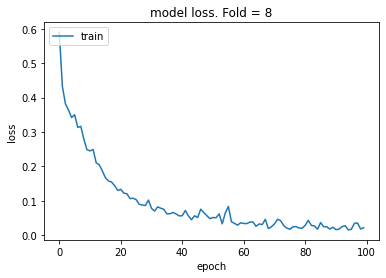

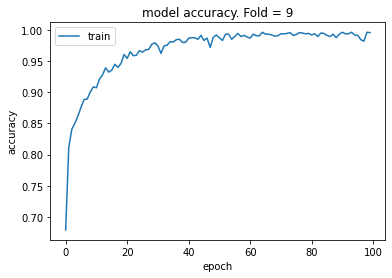

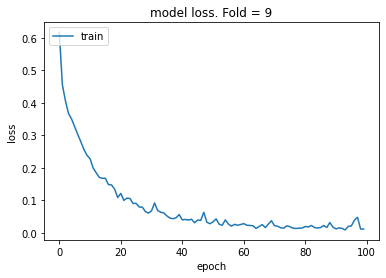

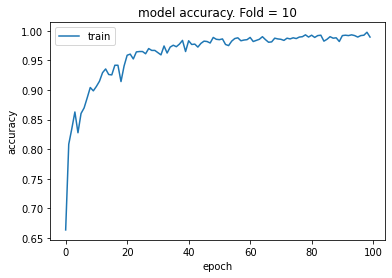

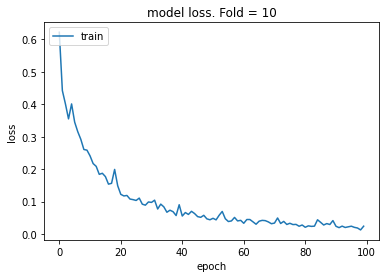

In [1]:
#!/usr/bin/env python
# coding: utf-8

# Author: Qian Qiu
# Year: 2022
# Language: python 3
# tensorflow >=2.2


from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
import pywt
import matplotlib.pyplot as plt

def loadData(filePath):
#     load data from filePath
    csvData = pd.read_csv(filePath)
    data = np.array(csvData)
    return data

def augment_data(data, label, num_augmentations):
#    Take data and label, and shift a random choice of the data, padding with zeroes, to produce an augmented dataset
#    This returns just the extra data generated, not the concatenation of the original and the extra.
    extra_data = []
    extra_label = []
    num_unaugmented = len(label)
    image_width = len(data[0][0])
    max_shift = int (image_width * 0.1 - 1.5)
    for i in range(num_augmentations):
        data_to_shift = np.random.randint(0, num_unaugmented)
        shift_by = np.random.randint(-max_shift, max_shift + 1)
        shifted = np.roll(data[data_to_shift], shift_by, axis = 1)
        extra_data.append(shifted)
        extra_label.append(label[data_to_shift])
    return (np.array(extra_data), np.array(extra_label))

def waveletPacket(data):
#     Get wavelet packet decomposition coefficient
#     Divided into 6 layers
    n=6
    num = len(data)
    height = data.shape[1]
    recof = []
    for i in range(num):
        for j in range(height):
            wpdata=data[i][j].flatten()
            wp = pywt.WaveletPacket(wpdata, wavelet='db4',maxlevel = n)
            for k in [node.path for node in wp.get_level(n, 'freq')]:
                recof.append(wp[k].data)
    recof = np.array(recof).reshape(num,height,-1,1)
    return recof

def get_TWavPadata(data):
#     Combine wavelet packet decomposition coefficients with original data into an array
    recof = waveletPacket(data)
    num = recof.shape[0]
    height = recof.shape[1]
    width_recof = recof.shape[2]
    width_data = data.shape[2]
    
#   The length of coefficients and original data are different 
    if(width_data>width_recof):
        width = width_data
    else:
        width = width_recof
    
    WavPadata = np.zeros((num,height,width,2))
    WavPadata[:,:,:width_data,:1] = data
    WavPadata[:,:,:width_recof,1:] = recof
    return WavPadata,width_data,width_recof

def T_WPD_cnn(inputshape1,inputshape2):
    input1 = layers.Input(inputshape1)
    input2 = layers.Input(inputshape2)
    
    cnn1 = single_cnn(inputshape1)(input1)
    cnn2 = single_cnn(inputshape2)(input2)

    combinedInput = layers.concatenate([cnn1, cnn2],axis = 2)
    
    x = layers.Flatten()(combinedInput)
    x = layers.Dense(16, activation = 'relu')(x)
    x = layers.Dense(1, activation = 'sigmoid')(x)
    adam = Adam(lr = 0.001)
    model = Model(inputs = [input1, input2],outputs = x)
    model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

    return model

def single_cnn(inputshape):
#     single channel of T_WPD_cnn
    height = inputshape[0]
    
    inputs = layers.Input(inputshape)
    x = layers.Conv2D(16,(height,10),activation = 'relu')(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.MaxPooling2D((1,2),strides=(1,2))(x)
    
    x = layers.Conv2D(8,(1,10),activation = 'relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.MaxPooling2D((1,2),strides=(1,2))(x)
    
    model = Model(inputs,outputs)
    return model

filePath = './cnn_data.csv'
seismic_data = loadData(filePath)
num_inputs = seismic_data.shape[1]-1
data = seismic_data[:, 0:num_inputs]
label = seismic_data[:, num_inputs]

image_num = data.shape[0]
image_channels = 1
image_height = 8
image_width = 1500
data = data.reshape(image_num, image_height, image_width, image_channels)

#parameters prepare
seed = 43
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)
fold_num = 0
fig_num = 0

total_TT = 0
total_TF = 0
total_FT = 0
total_FF = 0

total_acc_TT = []
total_acc_TF = []
total_acc_FT = []
total_acc_FF = []
AUC = []

for train, test in kfold.split(data, label):
    fold_num+=1
   
    #    split off 10% of the training data to act as validation
    data_train, data_validation, label_train, label_validation = train_test_split(data[train], label[train], test_size = 0.1,
                                                                                  random_state = seed, stratify = label[train])

#    obtain the index array that the label equal to 0 or 1
    indices_where_label_train_zeros = np.where(label_train == 0)[0]
    indices_where_label_train_one = np.where(label_train == 1)[0]
    
#    generate the same number of ones and zeros in the training set
    num_excess = len(indices_where_label_train_zeros) - len(indices_where_label_train_one)
    data_gen, label_gen = augment_data(data_train[indices_where_label_train_one],label_train[indices_where_label_train_one],num_excess)


    data_train = np.concatenate((data_train, data_gen))
    label_train = np.concatenate((label_train, label_gen))
    
#   trim the training set by removing from each end
    num_to_remove = int(len(data_train[0][0]) * 0.1 - 0.5)
    data_train = np.delete(data_train, np.s_[:num_to_remove], axis = 2)
    data_train = np.delete(data_train, np.s_[-num_to_remove:], axis = 2)

    data_validation = np.delete(data_validation, np.s_[:num_to_remove], axis = 2)
    data_validation = np.delete(data_validation, np.s_[-num_to_remove:], axis = 2)
    
    data_test = data[test]
    label_test = label[test]
    data_test = np.delete(data_test, np.s_[:num_to_remove], axis = 2)
    data_test = np.delete(data_test, np.s_[-num_to_remove:], axis = 2)

#     Convert to time and WPD coefficient data
    data_train,width_data,width_recof = get_TWavPadata(data_train)
    data_validation,width_data,width_recof = get_TWavPadata(data_validation)
    data_test,width_data,width_recof = get_TWavPadata(data_test)
    
#     train cnn model
    cnn_model = T_WPD_cnn(inputshape1=(data_train.shape[1],width_data,1),inputshape2=(data_train.shape[1],width_recof,1))
    history = cnn_model.fit([data_train[:,:,:width_data,:1],data_train[:,:,:width_recof,1:]], label_train,
                    validation_data = ([data_validation[:,:,:width_data,:1],data_validation[:,:,:width_recof,1:]], label_validation),
                    epochs = 100, batch_size = 50, verbose = 0)

    if fold_num == 1:
        cnn_model.summary()
        print("\nFold: 10" + "\tEpochs: 100")
    print ('Fold>>',fold_num)
    for ep in history.epoch:
        if ((ep+1)%5) == 0:
            print ('>> Epoch:', ep+1,'/',len(history.epoch),' >>> Loss:',history.history['loss'][ep], ' >>> Acc:', history.history['accuracy'][ep])
    
 #   plot
    fig_num += 1
    plt.figure(fig_num)
    plt.plot(history.history['accuracy'])
#         plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy. Fold = ' + str(fold_num))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc = 'upper left')

    fig_num += 1
    plt.figure(fig_num)
    plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
    plt.title('model loss. Fold = ' + str(fold_num))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc = 'upper left')   
        
#    cnn model test 
    scores = cnn_model.predict([data_test[:,:,:width_data,:1],data_test[:,:,:width_recof,1:]])
    label_predict = np.round(scores)

#    calculate the accuracy
    num_TT = 0
    num_TF = 0
    num_FT = 0
    num_FF = 0

    for i in range(len(label_test)):
        if label_test[i] == 1:
            if label_predict[i] == 1:
                num_TT += 1
            else:
                num_TF += 1
        else:
            if label_predict[i] == 0:
                num_FF += 1
            else:
                num_FT += 1

    print("Number of predicted events: " + str(len(label_test)))
    print("Number of test true events: " + str(num_TT + num_TF))
    print("Number of predicted true events: " + str(num_TT + num_FT))

    if (num_TT + num_TF) > 0:
        acc_TT = 100 * num_TT / (num_TT + num_TF)
        acc_TF = 100 * num_TF / (num_TT + num_TF)
        print("Accuracy rate of TT: %0.2f" % acc_TT)
        print("Accuracy rate of TF: %0.2f" % acc_TF)

    if (num_FT + num_FF) > 0:
        acc_FT = 100 * num_FT / (num_FT + num_FF)
        acc_FF = 100 * num_FF / (num_FT + num_FF)
        print("Accuracy rate of FT: %0.2f" % acc_FT)
        print("Accuracy rate of FF: %0.2f" % acc_FF)

    total_TT += num_TT
    total_TF += num_TF
    total_FT += num_FT
    total_FF += num_FF
    total_acc_TT.append(acc_TT)
    total_acc_TF.append(acc_TF)
    total_acc_FT.append(acc_FT)
    total_acc_FF.append(acc_FF)
    
#     AUC
    fpr, tpr, thresholds = metrics.roc_curve(label_test, scores, pos_label=1)
    auc = 100 * metrics.auc(fpr,tpr)
#     AUC = AUC + auc
    AUC.append(auc)
    print("The %dth fold AUC: %0.2f" % (fold_num,auc))

print("\nSUMMARY")
print("Total number of test true events = " + str(total_TT + total_TF))
print("Total number of predicted true events = " + str(total_TT + total_FT))
print("Overall fraction of true-positive: " + str(np.round(np.mean(total_acc_TT), decimals = 1)) + " +/- " + str(np.round(np.std(total_acc_TT), decimals = 1)) + "%")
print("Overall fraction of true-negative events: " + str(np.round(np.mean(total_acc_TF), decimals = 1)) + " +/- " + str(np.round(np.std(total_acc_TF), decimals = 1)) + "%")
print("Overall fraction of false-positive events: " + str(np.round(np.mean(total_acc_FT), decimals = 1)) + " +/- " + str(np.round(np.std(total_acc_FT), decimals = 1)) + "%")
print("Overall fraction of false-negative events: " + str(np.round(np.mean(total_acc_FF), decimals = 1)) + " +/- " + str(np.round(np.std(total_acc_FF), decimals = 1)) + "%")
print("Overall fraction of AUC: " + str(np.round(np.mean(AUC), decimals = 1)) + " +/- " + str(np.round(np.std(AUC), decimals = 1)))